# Dog Breed Classifier Project

## 4. Extracting features for similarity search

In this part, we will extract the bottleneck features (or feature vectors) of the pictures to calculate the degree of similarity between them.

In [1]:
import numpy as np
import random
from PIL import ImageFile
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model, Model
import matplotlib
import matplotlib.pyplot as plt
import os
import os.path
import math

Let's start by loading the model we fine-tuned in the previous notebook.

In [2]:
model = load_model('./model-finetuned.h5')

To evaluate the similarity between pictures, we will compare the feature vectors computed by the last convolutional layer of the model.  
Remove the top layers to go back to the output of the ResNet model.

In [3]:
model_slice = Model(model.input, model.layers[-4].output)
model_slice.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

The output shape of the last layer being (None, 2048), we will get a vector of 2048 dimensions for each picture.

In [4]:
TRAINING_DATA_DIR = 'images/train' # We will be working with pictures in the training dataset
TRAIN_SAMPLES = sum([len(filenames) for dirpath, dirnames, filenames in os.walk(TRAINING_DATA_DIR)]) # Number of pictures in the dataset
BATCH_SIZE = 16
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Set PIL to allow image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Get a list of files in the directory
files = list()
for (dirpath, dirnames, filenames) in os.walk(TRAINING_DATA_DIR):
    files += [os.path.join(dirpath, file) for file in filenames]

# Load pictures from their directory
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(TRAINING_DATA_DIR,
                                        target_size=(IMG_WIDTH,
                                                     IMG_HEIGHT),
                                        batch_size=BATCH_SIZE,
                                        class_mode=None, # We don't need the labels associated with each picture
                                        shuffle=False)

# Get 'predictions' from the model, actually the outputs of the last convolutional layer
features = model_slice.predict_generator(generator, math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE))

Found 6787 images belonging to 134 classes.


In [5]:
features.shape

(6787, 2048)

The 'features' array contains 2048 features for each of the 6787 pictures.

### Find the 'nearest neighbors'

We expect similar pictures to have similar features, i.e. a low Euclidian distance between their feature vectors.

In [6]:
neighbors = NearestNeighbors(n_neighbors=10, # Limit to 10 the number of neighbors to search
                             algorithm='brute', # The 'brute-force' algorithm calculates the distance between every item
                             metric='euclidean').fit(features)

In [7]:
# The method 'kneighbors' returns indices of and distances to the neighbors of the vector passed as a parameter
distances, indices = neighbors.kneighbors([features[42]]) # Here, we try with the 42th picture in our dataset

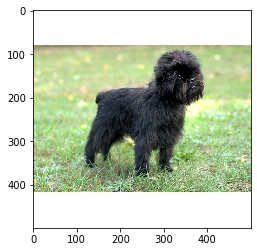

In [8]:
# Show the reference image (42th picture)
img = image.load_img(files[42])
plt.imshow(img)

Euclidian distance to reference picture : 0.00


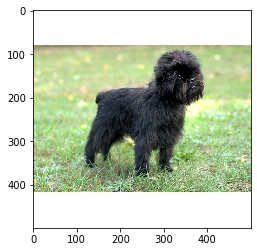

In [9]:
# Show the most similar image to the reference image as computed by the NearestNeighbors algorithm
img = image.load_img(files[indices[0][0]]) # The closest neighbor is at index 0
plt.imshow(img)
print("Euclidian distance to reference picture : {:.2f}".format(distances[0][0]))

The closest neighbor is actually the reference image itself! Let's see the next closest neighbor.

Euclidian distance to reference picture : 16.42


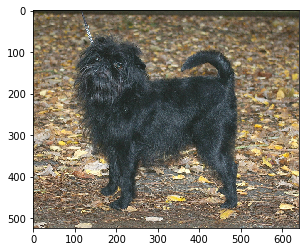

In [10]:
img = image.load_img(files[indices[0][1]]) # The second closest neighbor is at index 1
plt.imshow(img)
print("Euclidian distance to reference picture : {:.2f}".format(distances[0][1]))

Now let's pick a few random pictures from the entire dataset and visualize their closest neighbors.

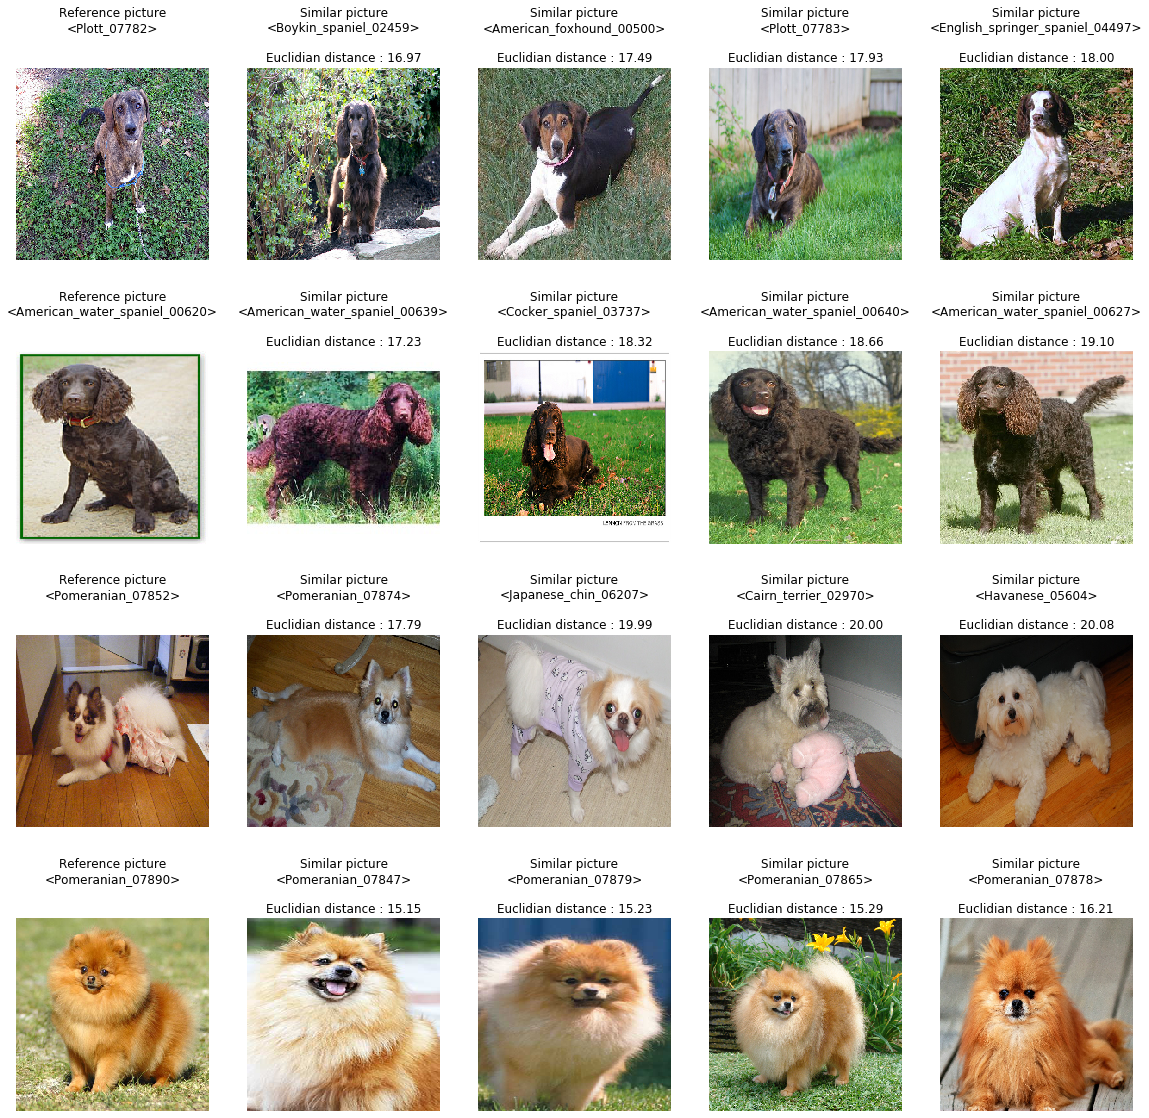

In [11]:
ROWS = 4 # Number of reference pictures
COLUMNS = 5 # Number of neighbors to display, including the reference picture

# Create a matplotlib figure
fig = plt.figure(figsize=(20, 20))
ax = []

# Randomly pick reference pictures from the dataset
rand_pics = random.sample(range(len(files)), ROWS)

for i, pic in enumerate(rand_pics):
    # Calculate the distances and indices of the closest neighbors to the current picture
    distances, indices = neighbors.kneighbors([features[pic]])

    # Plot the reference picture
    ax.append(fig.add_subplot(ROWS, COLUMNS, 1+i*COLUMNS))
    ax[-1].set_title("Reference picture" +
                     "\n<{}>".format(files[pic].split("\\")[-1].split(".")[0]) +
                     "\n\n")
    img = image.load_img(files[pic], target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.axis('off')
    plt.imshow(img)
    
    # Plot the most similar pictures
    # Start counting from index 1 to skip the most similar image (index 0) which is the reference image itself
    for j in range(1, COLUMNS):
        similar_image_path = files[indices[0][j]]

        ax.append(fig.add_subplot(ROWS, COLUMNS, i*COLUMNS + j+1))
        ax[-1].set_title("Similar picture" +
                         "\n<{}>".format(similar_image_path.split("\\")[-1].split(".")[0]) +
                         "\n\nEuclidian distance : {:.2f}".format(distances[0][j]))
        img = image.load_img(similar_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.axis('off')
        plt.imshow(img)

Now, a few interesting stats about our dataset:

In [12]:
# Calculate the distance between each picture and every other picture in the dataset
neighbors = NearestNeighbors(n_neighbors=len(features), # All neighbors
                             algorithm='brute',
                             metric='euclidean').fit(features)

distances, indices = neighbors.kneighbors(features)

print("Median Euclidian distance between all pictures: {:.2f}".format(np.median(distances)))
print("Maximum Euclidian distance between all pictures: {:.2f}".format(np.max(distances)))
print("Median Euclidian distance among most similar pictures: {:.2f}".format(np.median(distances[:, 1])))

Median Euclidian distance between all pictures: 27.51
Maximum Euclidian distance between all pictures: 71.34
Median Euclidian distance among most similar pictures: 15.99


### 2D visualization of high-dimensional data with t-SNE

(Wikipedia)  
T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization of high-dimensional data in a low-dimensional space of two or three dimensions.  
Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
  
In our case, the high-dimensional objects are the pictures, which each have 2048 dimensions.

The following code has been taken from the book "Practical Deep Learning for Cloud, Mobile, and Edge" by Anirudh Koul, Siddha Ganju, and Meher Kasam (O’Reilly).

In [13]:
n_components = 2
perplexity = 30
metric = 'euclidean'

tsne_results = TSNE(n_components=n_components,
                    perplexity=perplexity,
                    metric=metric).fit_transform(features)

Visualize the clusters of similar pictures :

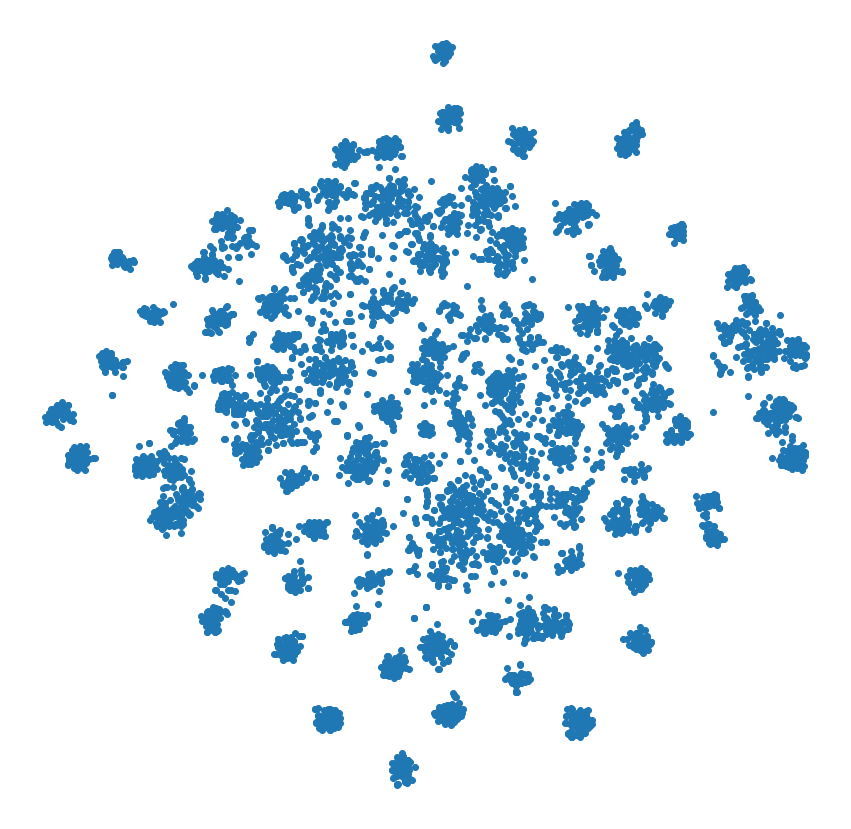

In [14]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(tsne_results[:, 0],
            tsne_results[:, 1])
plt.axis('off')
plt.show()

Helper function to plot images in 2D for t-SNE.

In [15]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

ImageFile.LOAD_TRUNCATED_IMAGES = True

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()
    
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.axis('off')
    plt.show()    

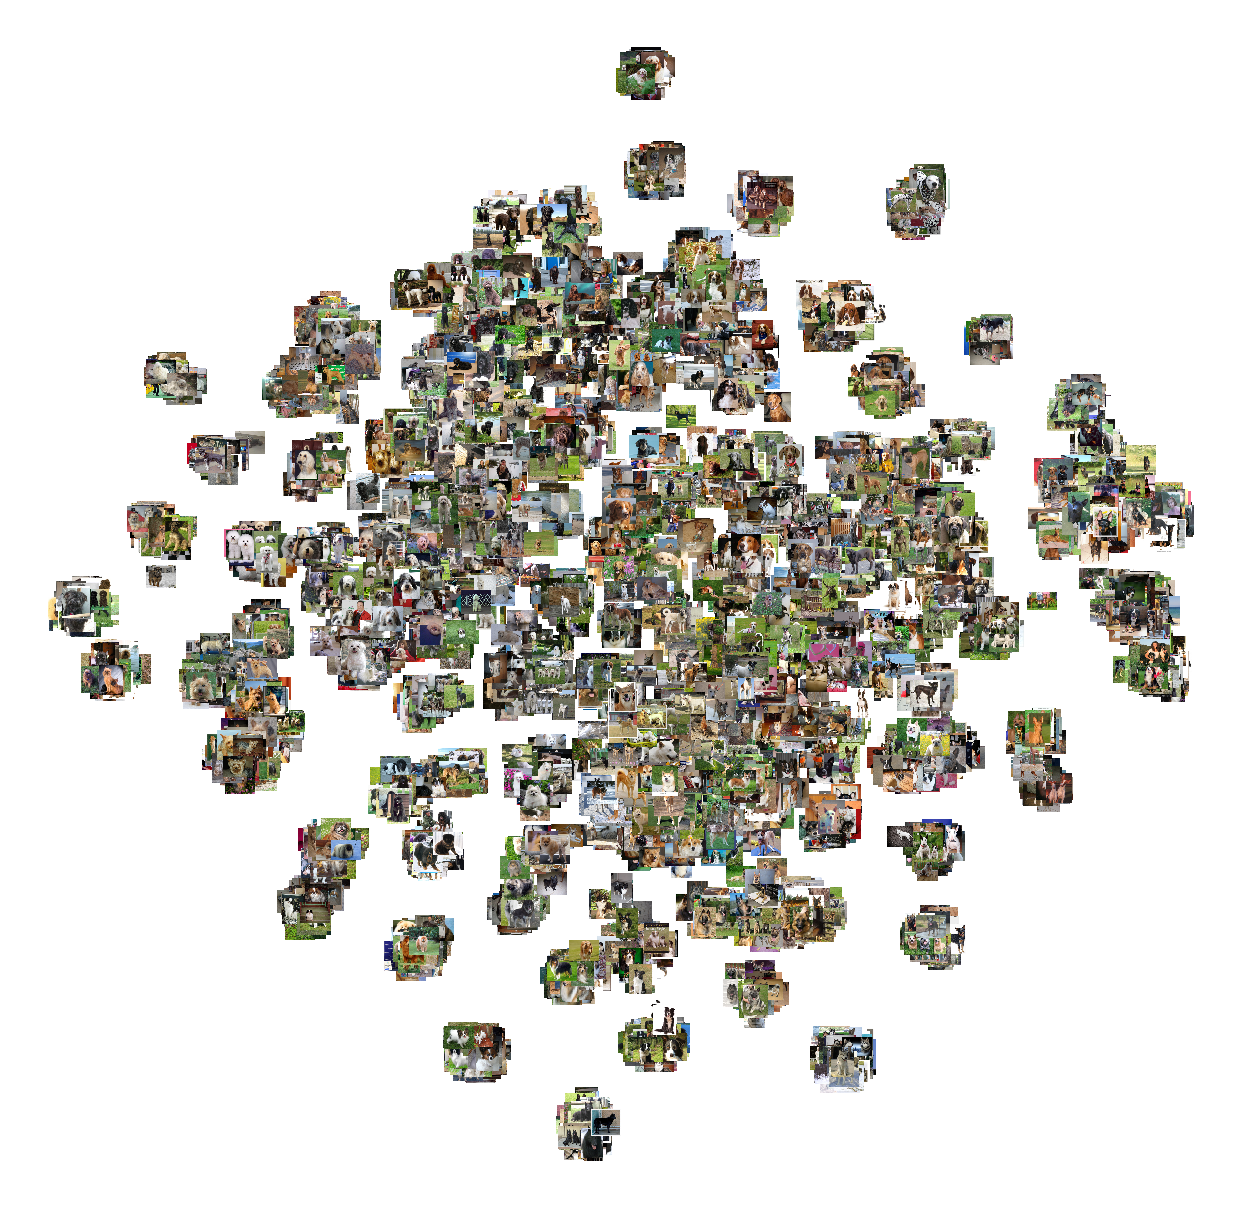

In [16]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], files)

Space the images evenly:

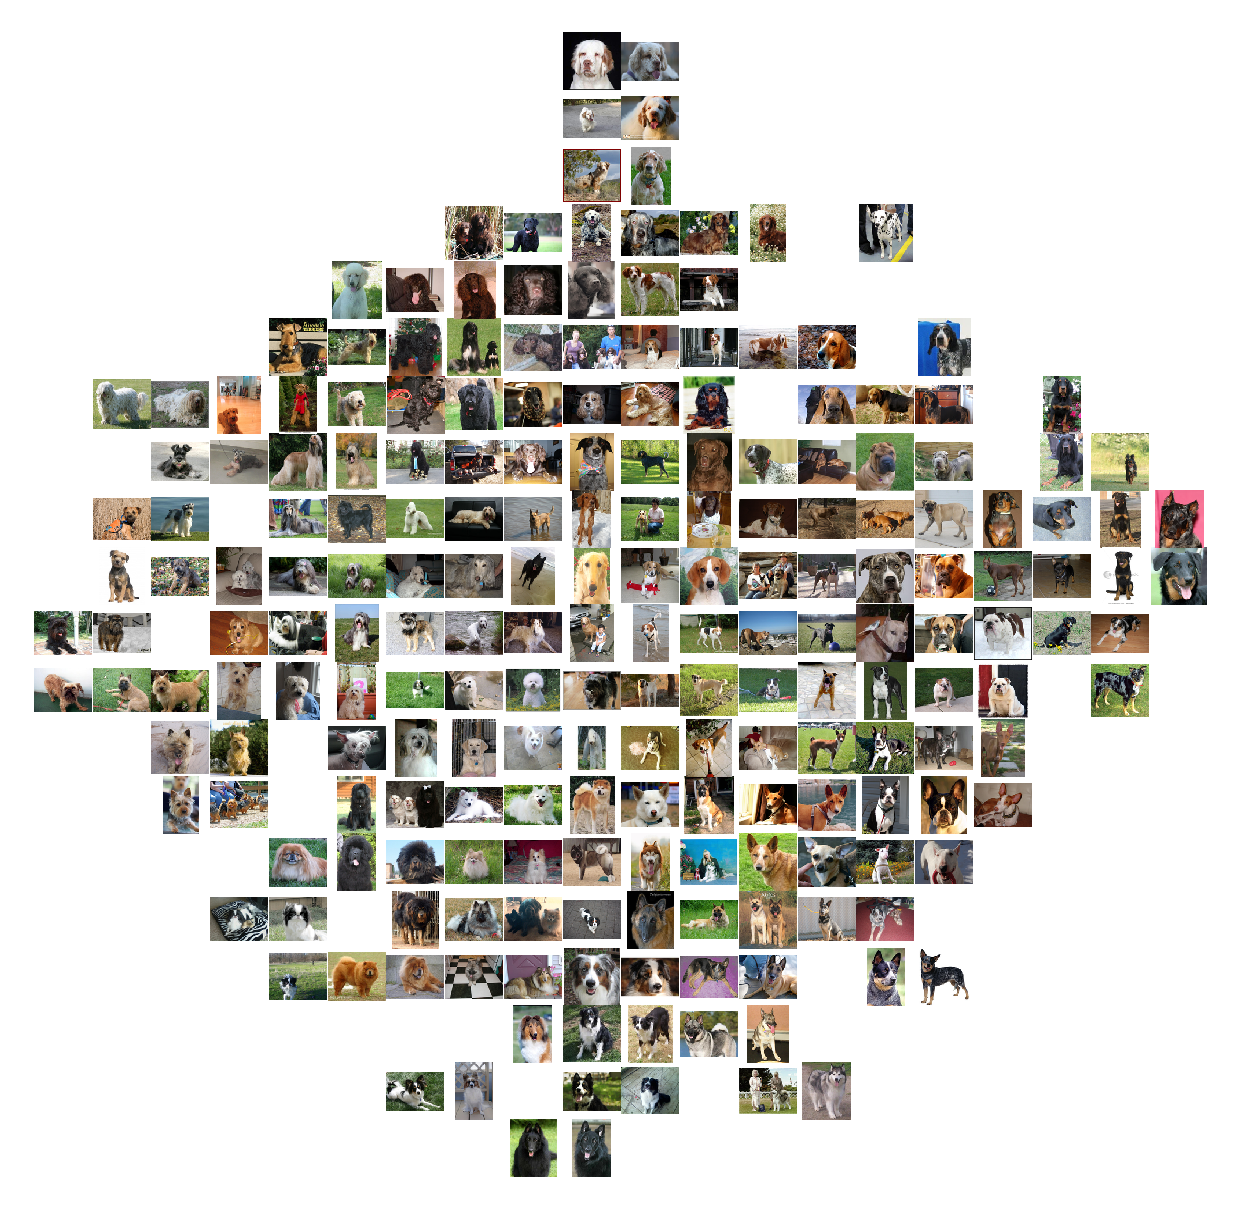

In [17]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.axis('off')
    plt.show()
    
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1], files)